## Nishika　中古マンション価格予測 2022夏の部
https://www.nishika.com/competitions/34/summary

概要  
・目的変数は、取引価格（総額）について常用対数をとった「取引価格（総額）_log」  
・予測精度の評価は、MAE

最終提出ファイル  
・LightGBMにて、目的変数を①『取引価格（総額）_log』、②『坪単価』の２つのモデルを作成    
・optunaにて部分的なベストパラメータの探索を複数回行った上、それらでの予測の平均値から最終予測値を算出

最終スコア：0.074365  
最終順位：497人参加中、9位

## 

## 準備

・必要なライブラリーをimport

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import glob
import lightgbm as lgb
import warnings
warnings.simplefilter('ignore', FutureWarning)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

## データの読み込みと大まかな中身の確認

・都道府県ごとにcsvデータとして保管されているため、一つにまとめて読み込み、基本統計量などを確認していく

In [2]:
# 47都道府県ごとのデータCVRを一つのCVRにまとめる
train_data = glob.glob('./train/*.csv')
train_list = []
for file in train_data:
    train_list.append(pd.read_csv(file, encoding='cp932'))
    train = pd.concat(train_list, axis=0, sort=True)

In [3]:
train.head()

,ID,今後の利用目的,前面道路：幅員（ｍ）,前面道路：方位,前面道路：種類,取引の事情等,取引価格（総額）_log,取引時点,土地の形状,地区名,地域,容積率（％）,市区町村コード,市区町村名,延床面積（㎡）,建ぺい率（％）,建物の構造,建築年,改装,最寄駅：名称,最寄駅：距離（分）,用途,種類,都市計画,都道府県名,間取り,間口,面積（㎡）
0,1000809,事務所,NaN,NaN,NaN,NaN,6.963788,2019年第3四半期,NaN,北１条西,NaN,400.0,1101,札幌市中央区,NaN,80.0,ＳＲＣ,1974/1/1,改装済,西１８丁目,5,NaN,中古マンション等,商業地域,北海道,オープンフロア,NaN,85
1,1108719,NaN,NaN,NaN,NaN,NaN,7.000000,2013年第1四半期,NaN,浪花町,NaN,200.0,1206,釧路市,NaN,60.0,ＲＣ,1995/1/1,未改装,釧路,10,住宅,中古マンション等,第１種住居地域,北海道,３ＬＤＫ,NaN,70
2,1028203,住宅,NaN,NaN,NaN,NaN,7.301030,2019年第4四半期,NaN,北４４条東,NaN,200.0,1103,札幌市東区,NaN,60.0,ＲＣ,1994/1/1,改装済,栄町(札幌),5,住宅,中古マンション等,第１種住居地域,北海道,３ＬＤＫ,NaN,70
3,1040438,NaN,NaN,NaN,NaN,NaN,7.255273,2009年第2四半期,NaN,月寒中央通,NaN,300.0,1105,札幌市豊平区,NaN,60.0,ＳＲＣ,2003/1/1,未改装,福住,4,住宅,中古マンション等,準工業地域,北海道,３ＬＤＫ,NaN,85
4,1100395,住宅,NaN,NaN,NaN,NaN,6.361728,2017年第1四半期,NaN,宮下通,NaN,600.0,1204,旭川市,NaN,80.0,ＳＲＣ,1989/1/1,未改装,旭川,3,住宅,中古マンション等,商業地域,北海道,１Ｋ,NaN,20


In [33]:
train.describe()

,ID,前面道路：幅員（ｍ）,前面道路：方位,前面道路：種類,取引価格（総額）_log,土地の形状,地域,容積率（％）,市区町村コード,延床面積（㎡）,建ぺい率（％）,間口
count,7.225740e+05,0.0,0.0,0.0,722574.000000,0.0,0.0,698413.000000,722574.000000,0.0,698413.000000,0.0
mean,1.849089e+07,NaN,NaN,NaN,7.227968,NaN,NaN,302.514787,18517.026688,NaN,67.668886,NaN
std,9.564795e+06,NaN,NaN,NaN,0.355394,NaN,NaN,148.299154,9593.618981,NaN,10.411635,NaN
min,1.000003e+06,NaN,NaN,NaN,2.653213,NaN,NaN,50.000000,1101.000000,NaN,30.000000,NaN
25%,1.306853e+07,NaN,NaN,NaN,7.041393,NaN,NaN,200.000000,13107.000000,NaN,60.000000,NaN
50%,1.402947e+07,NaN,NaN,NaN,7.278754,NaN,NaN,200.000000,14104.000000,NaN,60.000000,NaN
75%,2.703502e+07,NaN,NaN,NaN,7.462398,NaN,NaN,400.000000,27114.000000,NaN,80.000000,NaN
max,4.703512e+07,NaN,NaN,NaN,9.934498,NaN,NaN,1300.000000,47213.000000,NaN,80.000000,NaN


<AxesSubplot:xlabel='取引価格（総額）_log', ylabel='Density'>

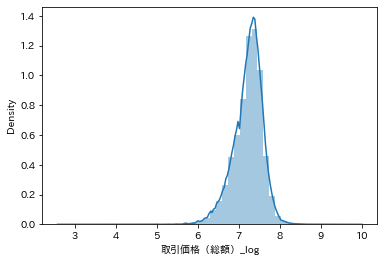

In [34]:
sns.distplot(train["取引価格（総額）_log"])

In [35]:
train.dtypes

ID                int64
今後の利用目的          object
前面道路：幅員（ｍ）      float64
前面道路：方位         float64
前面道路：種類         float64
取引の事情等           object
取引価格（総額）_log    float64
取引時点             object
土地の形状           float64
地区名              object
地域              float64
容積率（％）          float64
市区町村コード           int64
市区町村名            object
延床面積（㎡）         float64
建ぺい率（％）         float64
建物の構造            object
建築年              object
改装               object
最寄駅：名称           object
最寄駅：距離（分）        object
用途               object
種類               object
都市計画             object
都道府県名            object
間取り              object
間口              float64
面積（㎡）            object
dtype: object

In [36]:
train.columns

Index(['ID', '今後の利用目的', '前面道路：幅員（ｍ）', '前面道路：方位', '前面道路：種類', '取引の事情等',
       '取引価格（総額）_log', '取引時点', '土地の形状', '地区名', '地域', '容積率（％）', '市区町村コード',
       '市区町村名', '延床面積（㎡）', '建ぺい率（％）', '建物の構造', '建築年', '改装', '最寄駅：名称',
       '最寄駅：距離（分）', '用途', '種類', '都市計画', '都道府県名', '間取り', '間口', '面積（㎡）'],
      dtype='object')

In [37]:
# 欠損値の割合の確認
NaN_sum = train.isnull().sum()
rate_NaN = NaN_sum / train.shape[0]
rate_NaN

ID              0.000000
今後の利用目的         0.506412
前面道路：幅員（ｍ）      1.000000
前面道路：方位         1.000000
前面道路：種類         1.000000
取引の事情等          0.973785
取引価格（総額）_log    0.000000
取引時点            0.000000
土地の形状           1.000000
地区名             0.000924
地域              1.000000
容積率（％）          0.033437
市区町村コード         0.000000
市区町村名           0.000000
延床面積（㎡）         1.000000
建ぺい率（％）         0.033437
建物の構造           0.026505
建築年             0.029771
改装              0.094213
最寄駅：名称          0.003780
最寄駅：距離（分）       0.032048
用途              0.098067
種類              0.000000
都市計画            0.027427
都道府県名           0.000000
間取り             0.035833
間口              1.000000
面積（㎡）           0.000012
dtype: float64

## 前処理

・一定以上の欠損値を含む列を削除  
・建築年に関して、"1996/07/14","昭和35年","平成元年"と分類されていたため、すべて西暦に変換  
・面積、距離に関して、数値と文字列が混合していたため。すべて任意の数値に変換  
・取引年に関して、〇年第〇半期という表記だったため、4半期ごとに[0.25, 0.50, 0.75, 0.99]へと数値型に変換

In [3]:
# 一定以上の欠損値を含む列を削除
def drop_manyNuNcolumns(train,rate):
    NaN_sum = train.isnull().sum()
    rate_NaN = NaN_sum / train.shape[0]
    drop_list = list()
    for i in range(rate_NaN.shape[0]-1):
        if rate_NaN[i] > rate:
            drop_list.append(i)
        else:
            pass
    return train.drop(train.columns[drop_list], axis=1)

train = drop_manyNuNcolumns(train,0.99)

In [4]:
#建築年
def convert_wareki_to_seireki(year):
    if year == year:
        if year == '戦前':
            year = '昭和20年'

    #ある文字列を指定して、元々西暦の行は対象外に
        value = year[2:-1]
        if '/' in value:
            year = year[:4]
        elif '元' in value:
            value = 1
        else:
            value = int(value)
            
    #和暦ごとに年数を足す          
        if '昭和' in year:
            year = 1925+value
        elif '平成' in year:
            year = 1988+value
        elif '令和' in year:
            year = 2018+value
        else:
            pass
        return year

train['建築年'] = train['建築年'].apply(convert_wareki_to_seireki).astype(float)  # データフレームに関数を適用するときはapplyを利用

#面積：2000㎡以上を削除
train = train.drop(train[(train['面積（㎡）'] == "2000㎡以上")].index, axis=0)

#距離
    #対象の文字列を数値に変換するリストを作成する
dis = {"30分?60分": 45, "1H?1H30": 75, "1H30?2H": 105, "2H?": 120,}

    #float型に変換して再設定
train["最寄駅：距離（分）"] = train["最寄駅：距離（分）"].replace(dis).astype(float)

#取引時点
year = {
    "年第1四半期": ".25",
    "年第2四半期": ".5",
    "年第3四半期": ".75",
    "年第4四半期": ".99",
}
year_list = {}
year_replace = ""

for i in train["取引時点"].value_counts().keys():
    for k, j in year.items():
        if k in i:
            year_replace = i.replace(k,j)
    year_list[i] = year_replace

train["取引時点"] = train["取引時点"].replace(year_list).astype(float)

In [5]:
#変数選択
col_name =['取引の事情等', '市区町村名', '都道府県名', '地区名', '最寄駅：名称', '最寄駅：距離（分）', '間取り', '面積（㎡）', '建築年','建物の構造', '用途', '今後の利用目的', '都市計画', '建ぺい率（％）', '容積率（％）', '取引時点', '改装']
cat_cols = ['今後の利用目的','取引の事情等', '地区名','建物の構造', '改装', '最寄駅：名称', '用途', '都市計画', '都道府県名', '間取り']

In [6]:
#optuna実行のための欠損値補完
train[cat_cols] = train[cat_cols].fillna("欠損")
train["面積（㎡）"] = train["面積（㎡）"].fillna(10)
train["面積（㎡）"] = train["面積（㎡）"].astype(float)

In [7]:
train[col_name] = train[col_name].fillna(0)

In [8]:
train[['最寄駅：距離（分）', '面積（㎡）', '建築年', '建ぺい率（％）', '容積率（％）', '取引時点', '改装', '取引価格（総額）_log']]

,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引時点,改装,取引価格（総額）_log
0,5.0,85.0,1974.0,80.0,400.0,2019.75,改装済,6.963788
1,10.0,70.0,1995.0,60.0,200.0,2013.25,未改装,7.000000
2,5.0,70.0,1994.0,60.0,200.0,2019.99,改装済,7.301030
3,4.0,85.0,2003.0,60.0,300.0,2009.50,未改装,7.255273
4,3.0,20.0,1989.0,80.0,600.0,2017.25,未改装,6.361728
...,...,...,...,...,...,...,...,...
2082,1.0,65.0,2010.0,80.0,500.0,2010.99,未改装,7.462398
2083,9.0,20.0,1992.0,80.0,400.0,2013.75,未改装,6.477121
2084,0.0,60.0,1995.0,60.0,200.0,2021.50,未改装,7.278754
2085,45.0,75.0,1996.0,60.0,200.0,2019.99,未改装,7.301030


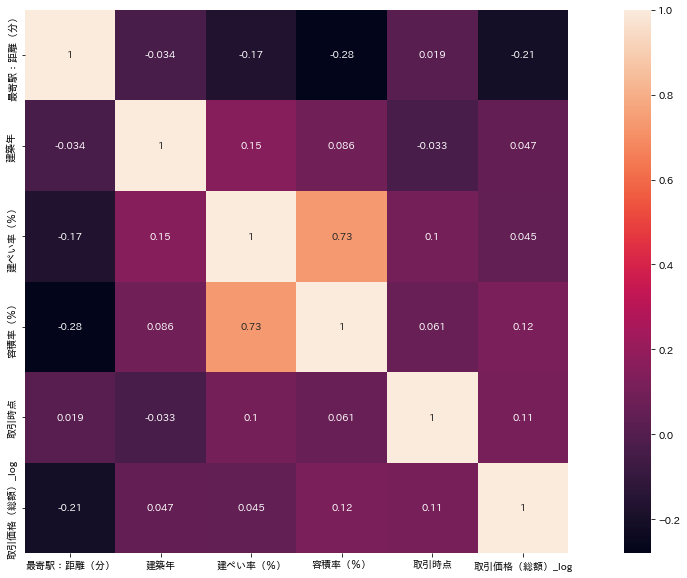

In [22]:
plt.figure(figsize = (20,10))
sns.heatmap(train[['最寄駅：距離（分）', '面積（㎡）', '建築年', '建ぺい率（％）', '容積率（％）', '取引時点', '取引価格（総額）_log']].corr(), square=True, annot=True)
plt.show()

<Figure size 1440x720 with 0 Axes>

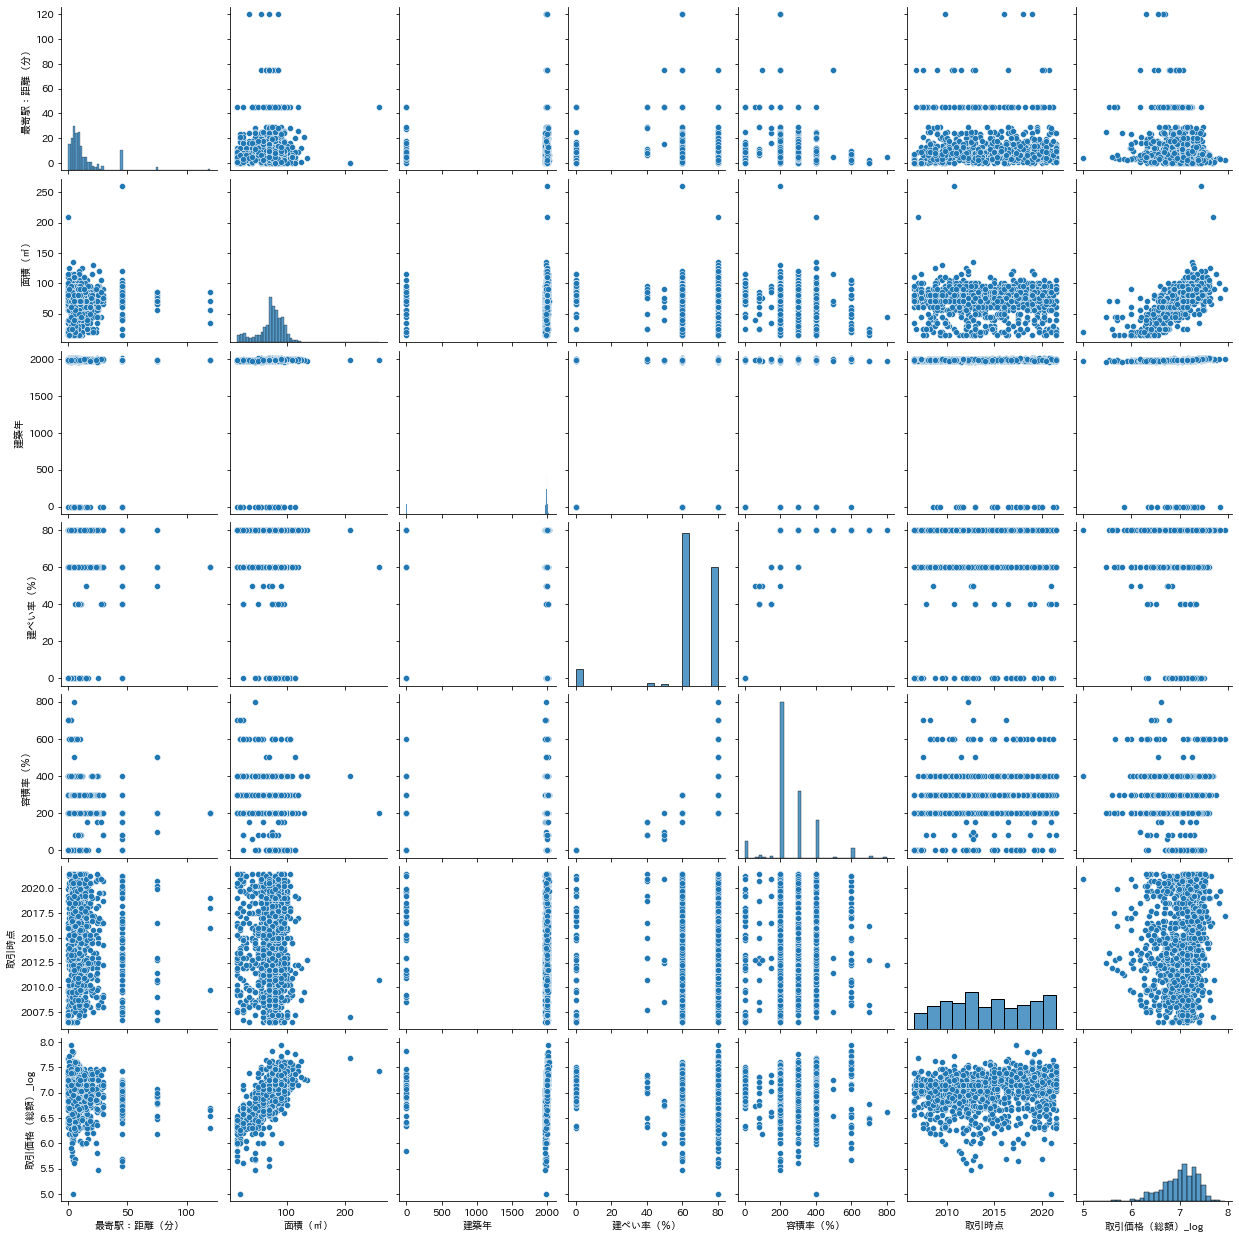

In [91]:
plt.figure(figsize = (20,10))
sns.pairplot(train[['最寄駅：距離（分）', '面積（㎡）', '建築年', '建ぺい率（％）', '容積率（％）', '取引時点', '取引価格（総額）_log']][:1000], diag_kind ='hist')

## 探索：複数パターンのデータセットの作成

・#1 新たな目的変数の坪単価の生成  
・#2 説明不可と思われるデータの抽出、および削除  
・#3 平均から遠い取引価格の削除  
・#4 古い取引時点のデータの削除  
・#5 取引時点の建築年数を追加

最終ファイルでは#1,2を採択

In [108]:
#1 新たな目的変数の生成
train["坪単価"]  = train["取引価格（総額）_log"]- np.log10(train["面積（㎡）"])

In [109]:
#2 データからでは読み取れなかった（説明できない）低い価格のID
lst= [1138834,  1006664,  8044520,  9041021,  9008590, 11027467, 11007964,
 12094239, 12093856, 12074721, 12032149, 12040548, 13425195, 13060399,
 13062408, 13273329, 13191588, 14259452, 14302447, 14076156, 14024861,
 15051341, 20066281, 20061364, 20048480, 20066286, 20054022, 20066283,
 20066279, 20054019, 20066265, 22062080, 22022421, 22087849, 22062089,
 22022422, 23227821, 25050026, 26055250, 27126059, 27212236, 27111147,
 27053143, 27185616, 27171327, 27099206, 28129501, 28173823, 29016611,
 40050598, 40150244]

In [110]:
    #上記を学習データから取り除く
train = train[~train["ID"].isin(lst)]

In [189]:
#3 取引価格の上下を学習から取り除く
train = train.drop(train[(train['取引価格（総額）_log'] >= 8)].index, axis=0)
train = train.drop(train[(train['取引価格（総額）_log'] <= 6.5)].index, axis=0)

In [233]:
#4 取引時点が古いものを取り除く
train = train.sort_values('取引時点', ascending=False)[:380000]

In [22]:
#5 取引時点の建築年数を追加
train["取引時築年数"]  = train["取引時点"]- train["建築年"]
col_name =["取引時築年数", '取引の事情等', '市区町村名', '都道府県名', '地区名', '最寄駅：名称', '最寄駅：距離（分）', '間取り', '面積（㎡）', '建築年','建物の構造', '用途', '今後の利用目的', '都市計画', '建ぺい率（％）', '容積率（％）', '取引時点', '改装']

## モデル構築（LGBM）

・目的変数を①『取引価格（総額）_log』、②『坪単価』の２つのモデルを作成    
・optunaにて部分的なベストパラメータの探索を複数回行った上、それらでの予測の平均値から最終予測値を算出

In [16]:
# 目的変数と説明変数の生成　モデル1
x = train[col_name]
y = train['取引価格（総額）_log']

x.shape, y.shape

((722527, 17), (722527,))

In [17]:
# 目的変数と説明変数の生成　モデル2
x = train[col_name]
y = train["坪単価"]

x.shape, y.shape

((722527, 17), (722527,))

In [ ]:
for c in x.columns:
    col_type = x[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        x[c] = x[c].astype('category')

In [22]:
#学習・テストデータへの分割
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, shuffle = True)

In [ ]:
#モデル構築
trains = lgb.Dataset(x_train, y_train)
valids = lgb.Dataset(x_test, y_test)

params = {
    'objective': 'regression_l1',
    'metric': 'mae',
    'max_depth': -1,
    'subsample_freq': 1,
    'learning_rate': 0.01,
    "boosting": "gbdt",
    "verbosity": -1,
    "random_state": 42,
    "num_boost_round":7000,
    "early_stopping_rounds": 100,
    'num_leaves': 3471,
    'feature_fraction': 0.5718461362837146,
    'bagging_fraction': 0.877025059209037,
    'min_data_in_leaf': 19,
    'lambda_l1': 0.4623075278206704,
    'lambda_l2': 11.471777121126554
}

model = lgb.train(params, trains, categorical_feature = cat_cols, valid_sets = [trains, valids], keep_training_booster = True, verbose_eval =100)

In [ ]:
#予測値の計算
train_pred = model.predict(x_train, num_iteration=model.best_iteration)
eval_pred = model.predict(x_test, num_iteration=model.best_iteration)

In [40]:
#MAEの計算
mae1 = mean_absolute_error(y_train, train_pred)
mae2 = mean_absolute_error(y_test, eval_pred)
print(['MAE1 : {:.5f}'.format(mae1),'MAE2 : {:.5f}'.format(mae2)])  # {:.3f}で小数点以下は3桁で表示

['MAE1 : 0.05701', 'MAE2 : 0.07644']


In [ ]:
#特徴量の寄与率
importance = pd.DataFrame(model.feature_importance(importance_type='gain'), index=x_train.columns, columns=['importance'])
importance = importance.sort_values('importance', ascending=False)
display(importance)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

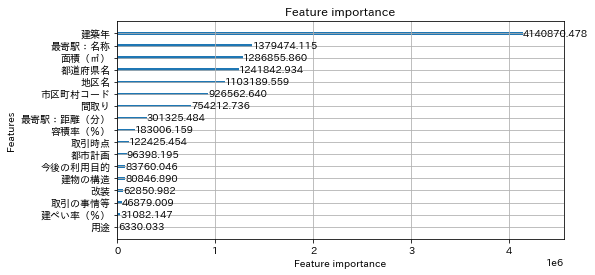

In [14]:
#特徴量重要度の可視化
lgb.plot_importance(model, figsize=(8,4), max_num_features=10, importance_type='gain')

## パラメータ探索

・実行に掛かる時間、およびPCスペックの都合より、部分探索を実行  
・同じ訓練データやモデルにおいて、num_leavesの範囲を変更し、複数のモデルを作成

In [ ]:
# # 全探索
# from optuna.integration import lightgbm as gbm

# trains = lgb.Dataset(x_train, y_train)
# valids = lgb.Dataset(x_test, y_test)

# # 固定するパラメータ
# params = {
#     "boosting_type": "gbdt",
#     'objective': 'regression_l1',
#     'metric': 'mae',
#     "boosting": "gbdt",
#     'learning_rate': 0.1,
#     "verbosity": -1,
#     "random_state": 42,
#     'subsample_freq': 1,
# }

# best_params, history = {}, []

# # Optunaで（5つの）パラメータ探索
# gbm = gbm.train(params, trains, 
#                   valid_sets=[trains, valids],
#                   verbose_eval=100,
#                   num_boost_round=10000,
#                   early_stopping_rounds=50
#                  )

# # 最適なパラメータの表示
# best_params = gbm.params
# print("Best params:", best_params)

In [ ]:
# 範囲指定をした上でoptuna
# 範囲やiterationが多いとbad allocationとして止まる？

import optuna
from sklearn.metrics import mean_absolute_error
#from optuna.integration import lightgbm as gbm

def objective(trial):
    param = {
        'objective': 'regression_l1',
        "metric": "mae",
        "max_depth":-1,
        'num_leaves': trial.suggest_int('num_leaves', 2500, 3500),
        "feature_fraction": trial.suggest_loguniform('feature_fraction', 0.4, 0.95),
        'subsample_freq': 1,
        "bagging_fraction":trial.suggest_loguniform('bagging_fraction', 0.8, 0.98),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2, 20),
        'learning_rate': 0.01,
        "boosting": "gbdt",
        "lambda_l1":trial.suggest_loguniform("lambda_l1", 0.1, 0.8),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1, 15),
        "verbosity": -1,
        "random_state": 42
    }

    
    trains = lgb.Dataset(x_train, y_train)
    valids = lgb.Dataset(x_test, y_test,reference=trains)

    model = lgb.train(
    param,
    trains,
    valid_sets=[trains, valids],
    num_boost_round=3000,
    early_stopping_rounds=20,
    verbose_eval =100,
   )

    eval_pred = model.predict(x_test, num_iteration=model.best_iteration)
    mae = mean_absolute_error(y_test, eval_pred)
    return mae

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=3)

In [20]:
study.best_value

0.06891958919303716

In [21]:
study.best_params

{'num_leaves': 3471,
 'feature_fraction': 0.5718461362837146,
 'bagging_fraction': 0.877025059209037,
 'min_data_in_leaf': 19,
 'lambda_l1': 0.4623075278206704,
 'lambda_l2': 11.471777121126554}

## 残差プロット、および詳細データの確認

・特に取引価格が3前後などの低価格帯において、正しく予測できていないデータが50コ程存在していた  
・目検でも法則性を判断しかねるデータであり、事故物件等なにかしらの事情があった可能性を考察した

In [ ]:
pred = model.predict(x, num_iteration=model.best_iteration)

In [ ]:
plt.scatter(pred, pred - y, color = 'blue')      # 残差をプロット 
plt.hlines(y = 0, xmin = 5, xmax = 9, color = 'black')   # x軸に沿った直線をプロット
plt.title('Residual Plot')                                # 図のタイトル
plt.xlabel('Predicted Values')                            # x軸のラベル
plt.ylabel('Residuals')                                   # y軸のラベル
plt.grid()                                                # グリッド線を表示

plt.show()                   

In [ ]:
train["Residuals"] = pred - y

In [ ]:
# train.to_csv('residual.csv', index=False)

In [10]:
df = pd.read_csv("residual.csv")

In [21]:
df.query("Residuals > 2").describe()

,ID,取引価格（総額）_log,取引時点,容積率（％）,市区町村コード,建ぺい率（％）,建築年,最寄駅：距離（分）,面積（㎡）,Residuals
count,5.100000e+01,51.000000,51.000000,42.000000,51.000000,42.000000,45.000000,50.000000,51.000000,51.000000
mean,1.899915e+07,3.703776,2013.834118,334.523810,19084.215686,68.809524,1983.733333,30.340000,55.980392,2.951928
std,8.233568e+06,0.893393,3.678848,157.142197,8233.080707,10.406935,10.694944,41.861584,33.091080,0.844628
min,1.006664e+06,2.653213,2006.990000,150.000000,1101.000000,50.000000,1956.000000,1.000000,10.000000,2.000042
25%,1.306140e+07,3.000000,2011.500000,200.000000,13105.000000,60.000000,1974.000000,4.000000,37.500000,2.140966
50%,2.006136e+07,3.176091,2013.500000,300.000000,20217.000000,60.000000,1984.000000,11.000000,55.000000,2.943825
75%,2.555264e+07,4.301030,2016.120000,400.000000,25654.000000,80.000000,1992.000000,22.500000,72.500000,3.945131
max,4.015024e+07,5.505150,2021.250000,800.000000,40135.000000,80.000000,2003.000000,120.000000,230.000000,4.121219


In [22]:
df.query("Residuals <= 2").describe()

,ID,取引価格（総額）_log,取引時点,容積率（％）,市区町村コード,建ぺい率（％）,建築年,最寄駅：距離（分）,面積（㎡）,Residuals
count,7.225230e+05,722523.000000,722523.000000,698371.000000,722523.000000,698371.000000,701017.000000,699367.000000,722514.000000,722523.000000
mean,1.849085e+07,7.228217,2014.488751,302.512862,18516.986652,67.668818,1995.412506,11.661122,58.492479,0.010717
std,9.564887e+06,0.354093,4.336655,148.298518,9593.711911,10.411639,11.628209,12.159365,26.032090,0.108561
min,1.000003e+06,3.934498,2005.750000,50.000000,1101.000000,30.000000,1945.000000,0.000000,10.000000,-1.487284
25%,1.306853e+07,7.041393,2010.990000,200.000000,13107.000000,60.000000,1988.000000,5.000000,45.000000,-0.023338
50%,1.402946e+07,7.278754,2014.750000,200.000000,14104.000000,60.000000,1997.000000,8.000000,65.000000,0.000096
75%,2.703502e+07,7.462398,2018.250000,400.000000,27114.000000,80.000000,2005.000000,14.000000,75.000000,0.028424
max,4.703512e+07,9.934498,2021.500000,1300.000000,47213.000000,80.000000,2022.000000,120.000000,2000.000000,1.987666


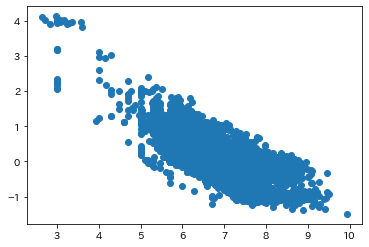

In [12]:
x = df['取引価格（総額）_log']
y = df['Residuals']
plt.scatter(x, y)

In [13]:
df.query("Residuals > 2")["ID"].array

<PandasArray>
[ 1138834,  1006664,  8044520,  9041021,  9008590, 11027467, 11007964,
 12094239, 12093856, 12074721, 12032149, 12040548, 13425195, 13060399,
 13062408, 13273329, 13191588, 14259452, 14302447, 14076156, 14024861,
 15051341, 20066281, 20061364, 20048480, 20066286, 20054022, 20066283,
 20066279, 20054019, 20066265, 22062080, 22022421, 22087849, 22062089,
 22022422, 23227821, 25050026, 26055250, 27126059, 27212236, 27111147,
 27053143, 27185616, 27171327, 27099206, 28129501, 28173823, 29016611,
 40050598, 40150244]
Length: 51, dtype: int64

In [138]:
# [1138834,  1006664,  8044520,  9041021,  9008590, 11027467, 11007964,
#  12094239, 12093856, 12074721, 12032149, 12040548, 13425195, 13060399,
#  13062408, 13273329, 13191588, 14259452, 14302447, 14076156, 14024861,
#  15051341, 20066281, 20061364, 20048480, 20066286, 20054022, 20066283,
#  20066279, 20054019, 20066265, 22062080, 22022421, 22087849, 22062089,
#  22022422, 23227821, 25050026, 26055250, 27126059, 27212236, 27111147,
#  27053143, 27185616, 27171327, 27099206, 28129501, 28173823, 29016611,
#  40050598, 40150244]

## テストデータの前処理

In [13]:
test = pd.read_csv('./test.csv',encoding='cp932')

In [14]:
#まとめて変換

# 和暦を西暦に
def convert_wareki_to_seireki(year):
    if year == year:
        if year == '戦前':
            year = '昭和20年'

#ある文字列を指定して、元々西暦の行は対象外に
        value = year[2:-1]
        if '/' in value:
            year = year[:4]
        elif '元' in value:
            value = 1
        else:
            value = int(value)
            
#和暦ごとに年数を足す          
        if '昭和' in year:
            year = 1925+value
        elif '平成' in year:
            year = 1988+value
        elif '令和' in year:
            year = 2018+value
        else:
            pass
        return year

test['建築年'] = test['建築年'].apply(convert_wareki_to_seireki).astype(float)

test["面積（㎡）"] = test["面積（㎡）"].replace({"2000㎡以上": "2000"}).astype(float)

    #対象の文字列を数値に変換するリストを作成する
dis = {"30分?60分": 45, "1H?1H30": 75, "1H30?2H": 105, "2H?": 120,}

    #float型に変換して再設定する
test["最寄駅：距離（分）"] = test["最寄駅：距離（分）"].replace(dis).astype(float)

#取引時点
year = {
    "年第1四半期": ".25",
    "年第2四半期": ".5",
    "年第3四半期": ".75",
    "年第4四半期": ".99",
}
year_list = {}
year_replace = ""

for i in test["取引時点"].value_counts().keys():
    for k, j in year.items():
        if k in i:
            year_replace = i.replace(k,j)
    year_list[i] = year_replace

test["取引時点"] = test["取引時点"].replace(year_list).astype(float)

In [15]:
# 目的変数と説明変数の生成
test_x = test[col_name]

## テストデータでの予測から提出ファイルの確認

最終的には、  
①『取引価格（総額）_log』で全データを学習したモデル、  
②『取引価格（総額）_log』で残差<2のみデータを学習したモデル、  
③『坪単価』で全データで学習したモデル（範囲指定のOptunaによる2パターンを用意）   
による合算のファイルを提出

In [ ]:
for c in test_x.columns:
    col_type = test_x[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        test_x[c] = test_x[c].astype('category')

In [17]:
test_pred = model.predict(test_x, num_iteration = model.best_iteration) + np.log10(test["面積（㎡）"])
test_pred
print(len(test_pred))

21005


In [ ]:
#予測ファイルの確認
sub = pd.read_csv('./submission12.csv',encoding='cp932')
sub.describe()

,ID,取引価格（総額）_log
count,2.100500e+04,21005.000000
mean,1.875575e+07,7.308007
std,9.388301e+06,0.326577
min,1.000078e+06,5.729086
25%,1.307743e+07,7.128425
50%,1.405303e+07,7.343158
75%,2.706261e+07,7.523074
max,4.702414e+07,8.885879


In [18]:
#提出ファイルの出力
test['取引価格（総額）_log'] = test_pred
sub = pd.merge(test[['ID']], test[['ID', '取引価格（総額）_log']], on='ID')
sub.to_csv('submission18.csv', index=False)

In [20]:
#複数の予測ファイルより再度予測の算出
sam1= pd.read_csv('./submission19.csv')
sam2= pd.read_csv('./submission8.csv')

sam3 = sam2
sam3['取引価格（総額）_log'] = (sam1['取引価格（総額）_log'] + sam2['取引価格（総額）_log')/2

sam3.to_csv('submission20.csv', index=False)

## 

## 振り返り・感じたこと・考察など

・煩雑さを考慮して、前処理はテストデータ含めて一括で行うべきであったと思う  
・Optunaを実施しても、PCスペックの問題でearly stopがかかるまで学習できず、AWSなどを活用できれば精度が上がったかもしれない  
　└特徴量を削除しても精度が落ちないような枠組みを作ることができれば、データ容量は下がり、現環境でも対応できたかも  
・残差プロットを確認するなど、予測したものに対する考察と対処が不十分のように感じてはいたが、手が届かなかった  
・LGBM以外のモデルでの精度上げについて中途半端に終わっているため、それらの実施およびスタッキングにトライしたかった

## 

##　以下、振り返り用メモ
## 重回帰

https://self-development.info/python%E3%81%A7%E7%B7%9A%E5%BD%A2%E5%9B%9E%E5%B8%B0%E3%81%AE%E9%87%8D%E5%9B%9E%E5%B8%B0%E5%88%86%E6%9E%90%E3%82%92%E8%A1%8C%E3%81%86%E6%96%B9%E6%B3%95%E3%80%90%E6%A9%9F%E4%BC%9A%E5%AD%A6%E7%BF%92/

In [84]:
col_name = ['最寄駅：距離（分）','改装','建築年','面積（㎡）','容積率（％）','建ぺい率（％）']
x = train[col_name].values
y = train['取引価格（総額）_log'].values

x.shape, y.shape

((722476, 6), (722476,))

In [85]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [86]:
#lasso回帰＝　L1正則化による回帰
#変数のスケールが罰則に影響を与える
#小さな値が入る変数の係数は大きくなりがちで、罰則の影響を受けがちのため、標準化しておく

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(x_train)
x_train = scaler.transform(x_train)

C:\Users\kokam\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.677498639455735, tolerance: 5.064861434540203
  model = cd_fast.enet_coordinate_descent_gram(


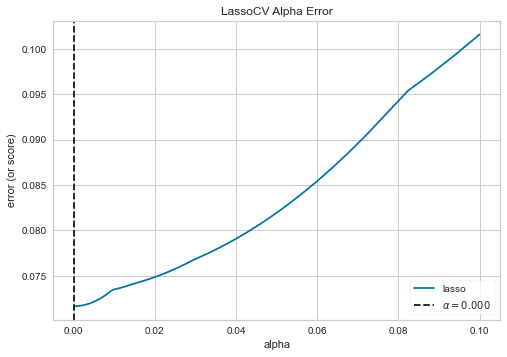

In [87]:
from yellowbrick.regressor import AlphaSelection 
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt

alphas = np.logspace(-15, -1, 500)
model_cv = LassoCV(alphas = alphas)
visualizer = AlphaSelection(model_cv)
visualizer.fit(x_train, y_train)
visualizer.show()
plt.show()

In [88]:
from sklearn.linear_model import Lasso
model = Lasso(alpha=0.001)
model.fit(x_train, y_train)

Lasso(alpha=0.001)

In [89]:
model.intercept_, model.coef_

(7.228428035564127,
 array([-0.08869915, -0.01576869,  0.13676738,  0.15823491,  0.08557433,
        -0.06625098]))

In [90]:
#決定係数で評価
from sklearn.metrics import r2_score

pred_train = model.predict(x_train)
r2_score(y_true = y_train, y_pred = pred_train)

0.4270845215400564

In [91]:
from sklearn.metrics import r2_score

x_test = scaler.transform(x_test)
pred_test = model.predict(x_test)
r2_score(y_test, pred_test)

0.42664185295602164

In [93]:
#R2の計算
train_pred = model.predict(x_train)
eval_pred = model.predict(x_test)

from sklearn.metrics import r2_score
train_score = r2_score(y_train, train_pred)
eval_score = r2_score(y_test, eval_pred)
train_score, eval_score

(0.4270845215400564, 0.42664185295602164)

In [94]:
# MAEの計算
from sklearn.metrics import mean_absolute_error
mae1 = mean_absolute_error(y_train, train_pred)
mae2 = mean_absolute_error(y_test, eval_pred)
print(['MAE1 : {:.5f}'.format(mae1),'MAE2 : {:.5f}'.format(mae2)])  # {:.3f}で小数点以下は3桁で表示

['MAE1 : 0.20190', 'MAE2 : 0.20204']


## ランダムフォレスト

https://camp.trainocate.co.jp/magazine/python-random-forest/
https://di-acc2.com/programming/python/13877/

In [95]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score

In [96]:
col_name = ['最寄駅：距離（分）','建築年','面積（㎡）','容積率（％）','建ぺい率（％）']
x = train[col_name].values
y = train['取引価格（総額）_log'].values

In [97]:
# 学習モデルを作成
model = RandomForestRegressor(max_depth = 15)

# 学習モデルにテストデータを与えて学習させる
model.fit(x_train, y_train)

RandomForestRegressor(max_depth=15)

In [98]:
x_train, x_test, y_train, y_test = train_test_split(
   x, y, test_size=0.3, random_state=0)

print(len(x_train)),print(len(x_test)),print(len(y_train)),print(len(y_test))

505733
216743
505733
216743


(None, None, None, None)

In [99]:
# 学習モデルを作成
model = RandomForestRegressor(max_depth = 15)

# 学習モデルにテストデータを与えて学習させる
model.fit(x_train, y_train)

RandomForestRegressor(max_depth=15)

In [100]:
from sklearn.metrics import r2_score            # 決定係数
from sklearn.metrics import mean_squared_error  # RMSE

# 予測値
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

# 平均平方二乗誤差(RMSE)
print('RMSE 学習: %.2f, テスト: %.2f' % (
        mean_squared_error(y_train, train_pred, squared=False), # 学習
        mean_squared_error(y_test, test_pred, squared=False)    # テスト
      ))

# 決定係数(R^2)
print('R^2 学習: %.2f, テスト: %.2f' % (
        r2_score(y_train, y_train_pred), # 学習
        r2_score(y_test, y_test_pred)    # テスト
      ))

RMSE 学習: 0.21, テスト: 0.22
R^2 学習: 0.66, テスト: 0.62


In [ ]:
# RMSE 学習: 0.16, テスト: 0.17
# R^2 学習: 0.80, テスト: 0.76

In [ ]:
# ['MAE1 : 0.11043', 'MAE2 : 0.11947']

In [30]:
# MAEの計算
from sklearn.metrics import mean_absolute_error
mae1 = mean_absolute_error(y_train, train_pred)
mae2 = mean_absolute_error(y_test, eval_pred)
print(['MAE1 : {:.5f}'.format(mae1),'MAE2 : {:.5f}'.format(mae2)])  # {:.3f}で小数点以下は3桁で表示

['MAE1 : 0.11043', 'MAE2 : 0.11947']


## XGBoost

In [19]:
from sklearn import preprocessing

for column in col_name:
    le = preprocessing.LabelEncoder()
    le.fit(train[column])
    train[column] = le.transform(train[column])

In [20]:
# 目的変数と説明変数の生成
#x = train.drop(['取引価格（総額）_log'], axis=1)
x = train[col_name]
y = train['取引価格（総額）_log']

x.shape, y.shape

((722476, 17), (722476,))

In [79]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [80]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test =train_test_split(x, y, test_size=0.3, random_state=0)

In [81]:
trains = xgb.DMatrix(x_train, y_train)
valids = xgb.DMatrix(x_test, y_test)

xgb = xgb.XGBRegressor(objective='reg:squarederror',
                       booster='gbtree',
                       max_depth=12,
                       reg_alpha = 0.1,
                       reg_lambda = 5,
                       min_child_weight = 0.5,
                       n_estimators=3000,
                       learning_rate=0.01,
                       random_state=2525)

xgb.fit(x_train, y_train,
        eval_set=[(x_train, y_train,),(x_test, y_test)],
        eval_metric='mae',
        early_stopping_rounds=20,
        verbose =100
       )

# 直前に上から実行しないとDMatrixが動かないことが多い

[0]	validation_0-mae:6.66116	validation_1-mae:6.66049
[100]	validation_0-mae:2.43907	validation_1-mae:2.43866
[200]	validation_0-mae:0.89525	validation_1-mae:0.89511
[300]	validation_0-mae:0.33888	validation_1-mae:0.33977
[400]	validation_0-mae:0.15394	validation_1-mae:0.15648
[500]	validation_0-mae:0.10436	validation_1-mae:0.10836
[600]	validation_0-mae:0.09113	validation_1-mae:0.09621
[700]	validation_0-mae:0.08580	validation_1-mae:0.09178
[800]	validation_0-mae:0.08217	validation_1-mae:0.08898
[900]	validation_0-mae:0.07910	validation_1-mae:0.08678
[1000]	validation_0-mae:0.07681	validation_1-mae:0.08522
[1100]	validation_0-mae:0.07481	validation_1-mae:0.08391
[1200]	validation_0-mae:0.07301	validation_1-mae:0.08280
[1300]	validation_0-mae:0.07149	validation_1-mae:0.08195
[1400]	validation_0-mae:0.07013	validation_1-mae:0.08123
[1500]	validation_0-mae:0.06894	validation_1-mae:0.08061
[1600]	validation_0-mae:0.06769	validation_1-mae:0.07993
[1700]	validation_0-mae:0.06672	validation_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=0.5,
             missing=nan, monotone_constraints='()', n_estimators=3000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=2525,
             reg_alpha=0.1, reg_lambda=5, ...)

In [83]:
# MAEの計算
train_pred = xgb.predict(x_train)
eval_pred = xgb.predict(x_test)

from sklearn.metrics import mean_absolute_error
mae1 = mean_absolute_error(y_train, train_pred)
mae2 = mean_absolute_error(y_test, eval_pred)
print(['MAE1 : {:.5f}'.format(mae1),'MAE2 : {:.5f}'.format(mae2)])  # {:.3f}で小数点以下は3桁で表示

['MAE1 : 0.05859', 'MAE2 : 0.07629']


## LGBM

In [109]:
import lightgbm as lgb

In [ ]:
x = train.drop(['取引価格（総額）_log'],1).values
y = train['取引価格（総額）_log'].values

In [111]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [ ]:
trains = lgb.Dataset(x_train, y_train)
valids = lgb.Dataset(x_test, y_test)

params = {"objective":"regression", "metrics":"mae"}

model = lgb.train(params, trains, valid_sets = valids, num_boost_round=1000, early_stopping_rounds=100)

#実行後、1000出てくるまで待つ

In [113]:
train_pred = model.predict(x_train, num_iteration=model.best_iteration)
eval_pred = model.predict(x_test, num_iteration=model.best_iteration)

from sklearn.metrics import r2_score
train_score = r2_score(y_train, train_pred)
eval_score = r2_score(y_test, eval_pred)
train_score, eval_score

(0.8011133950587241, 0.7873606362301249)

In [ ]:
print(train[col_name].columns)

In [ ]:
lgb.plot_importance(model, figsize=(12,8), max_num_features=50, importance_type='gain')

ダミー変数を使う場合

https://qiita.com/lystahi/items/9ddcf2cf87df63f857c8

In [196]:
#ダミー変数で足りない列を補完する

def fill_missing_columns(df_a, df_b):
    columns_for_b = set(df_a.columns) - set(df_b.columns)
    for column in columns_for_b:
        df_b[column] = 0

In [197]:
train_t = train.drop("取引価格（総額）_log", axis=1)
fill_missing_columns(train_t, test)

In [198]:
#テストにだけある列も削除する
columns = (set(test.columns) - set(train_t.columns))
columns

{'用途_事務所、作業場'}

In [199]:
test = test.drop(["用途_事務所、作業場"], axis=1)
    
train_t.shape, test.shape

((722574, 115), (21005, 115))

In [168]:
# データフレーム同士のカラム名の差分を取得・比較する方法rain.columns)))
# testにあって、trainにないもの ／ trainにあって、testにないもの
print(list(filter(lambda x: x not in train_t.columns,  test.columns))), print(list(filter(lambda x: x not in test.columns,  train_t.columns)))

[]
[]


(None, None)

k分割法の場合

https://blog.amedama.jp/entry/2018/06/21/235951

In [64]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

In [ ]:
# # カテゴリ変数の変換
# x = train[['市区町村コード', '最寄駅：距離（分）', '面積（㎡）', '建築年', '建ぺい率（％）', '容積率（％）', '取引時点']].values
# y = y.values

# valid_scores = []
# models = []
# kf = KFold(n_splits=10, shuffle=True, random_state=42)

# # KFoldクラスで分割した回数だけ実行
# for fold, (train_indices, valid_indices) in enumerate(kf.split(x)):
#     X_train, X_valid = x[train_indices], x[valid_indices]
#     y_train, y_valid = y[train_indices], y[valid_indices]
#     lgb_train = lgb.Dataset(X_train, y_train)
#     lgb_eval = lgb.Dataset(X_valid, y_valid)

In [47]:
valid_scores = []
models = []
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# KFoldクラスで分割した回数だけ実行
for i, j in kf.split(x):
    x_train, x_valid = x.iloc[i], x.iloc[j]
    y_train, y_valid = y.iloc[i], y.iloc[j]
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid)

In [ ]:
params = {
    'objective': 'regression',
    'metric': 'mae',
    'num_leaves': 3000,
    'max_depth': -1,
    "feature_fraction": 0.8,
    'subsample_freq': 1,
    "bagging_fraction": 0.95,
    'min_data_in_leaf': 2,
    'learning_rate': 0.03,
    "boosting": "gbdt",
    "lambda_l1": 0.1,
    "lambda_l2": 10,
    "verbosity": -1,
    "random_state": 42,
    "num_boost_round": 15000,
    "early_stopping_rounds": 150
}

evaluation_results = {}  

model = lgb.train(params, lgb_train, valid_sets = lgb_eval, verbose_eval =100)
#実行後、1000出てくるまで待つ

In [ ]:
from sklearn.metrics import mean_absolute_error

y_valid_pred = model.predict(X_valid)
score = mean_absolute_error(y_valid, y_valid_pred)
print(f'fold {fold} MAE: {score}')
valid_scores.append(score)

models.append(model)

cv_score = np.mean(valid_scores)
print(f'CV score: {cv_score}')

## ニューラルネットワーク

In [119]:
col_name =['取引の事情等', '市区町村名', '都道府県名', '地区名', '最寄駅：名称', '最寄駅：距離（分）', '間取り', '面積（㎡）', '建築年','建物の構造', '用途', '今後の利用目的', '都市計画', '建ぺい率（％）', '容積率（％）', '取引時点', '改装']
cat_cols = ['取引の事情等', '市区町村名','都道府県名','地区名', '改装', '最寄駅：名称', '間取り', '建物の構造', '用途', '今後の利用目的', '都市計画']

In [120]:
train[cat_cols] = train[cat_cols].fillna("欠損")

In [123]:
from sklearn import preprocessing

for column in cat_cols:
    le = preprocessing.LabelEncoder()
    le.fit(train[column])
    train[column] = le.transform(train[column])

In [127]:
train[col_name] = train[col_name].fillna(0)
train[col_name].head()

,取引の事情等,市区町村名,都道府県名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装
0,3,345,4,2318,3358,5.0,0,85.0,1974.0,9,20,1,0,80.0,400.0,2019.75,0
1,3,577,4,8135,3547,10.0,39,70.0,1995.0,5,5,4,11,60.0,200.0,2013.25,1
2,3,350,4,2387,2291,5.0,39,70.0,1994.0,5,5,2,11,60.0,200.0,2019.99,0
3,3,354,4,6433,2897,4.0,39,85.0,2003.0,9,5,4,7,60.0,300.0,2009.50,1
4,3,336,4,4615,1988,3.0,7,20.0,1989.0,9,5,2,0,80.0,600.0,2017.25,1


In [128]:
# 目的変数と説明変数の生成
#x = train.drop(['取引価格（総額）_log'], axis=1)
x = train[col_name]
y = train['取引価格（総額）_log']

x.shape, y.shape

((722476, 17), (722476,))

In [129]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test =train_test_split(x, y, test_size=0.2, random_state=0, shuffle = True)

In [133]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 100, 200,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=20, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=True, warm_start=False)

In [134]:
mlp.fit(x_train, y_train)

Iteration 1, loss = 49.61132012
Iteration 2, loss = 7.18549079
Iteration 3, loss = 2.18900237
Iteration 4, loss = 0.72870382
Iteration 5, loss = 0.30090681
Iteration 6, loss = 0.10795788
Iteration 7, loss = 0.07165837
Iteration 8, loss = 0.05592477
Iteration 9, loss = 0.04465494
Iteration 10, loss = 0.04236591
Iteration 11, loss = 0.04162724
Iteration 12, loss = 0.04075996
Iteration 13, loss = 0.03900536
Iteration 14, loss = 0.03789498
Iteration 15, loss = 0.03668432
Iteration 16, loss = 0.03553639
Iteration 17, loss = 0.03486761
Iteration 18, loss = 0.03400450
Iteration 19, loss = 0.03354083
Iteration 20, loss = 0.03278007
Iteration 21, loss = 0.03270832
Iteration 22, loss = 0.03206245
Iteration 23, loss = 0.03202093
Iteration 24, loss = 0.03177611
Iteration 25, loss = 0.03133984
Iteration 26, loss = 0.03121693
Iteration 27, loss = 0.03108856
Iteration 28, loss = 0.03091730
Iteration 29, loss = 0.03050647
Iteration 30, loss = 0.03076204


C:\Users\kokam\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(10, 100, 200), max_iter=30, random_state=42,
             verbose=True)

In [135]:
# MAEの計算
from sklearn.metrics import mean_absolute_error

train_pred = mlp.predict(x_train) 
eval_pred = mlp.predict(x_test)

mae1 = mean_absolute_error(y_train, train_pred)
mae2 = mean_absolute_error(y_test, eval_pred)
print(['MAE1 : {:.5f}'.format(mae1),'MAE2 : {:.5f}'.format(mae2)])  # {:.3f}で小数点以下は3桁で表示

['MAE1 : 0.19917', 'MAE2 : 0.19919']


In [ ]:
# MLPRegressor(hidden_layer_sizes=(10, 10), random_state=42)
# ['MAE1 : 0.21493', 'MAE2 : 0.21430']

# MLPRegressor(hidden_layer_sizes=(30, 30), random_state=42)
# ['MAE1 : 0.18084', 'MAE2 : 0.17992']

# MLPRegressor(hidden_layer_sizes=(10, 10, 10, 10), random_state=42)
# ['MAE1 : 0.17760', 'MAE2 : 0.17710']

# MLPRegressor(hidden_layer_sizes=(20, 20, 20, 20), random_state=42)
# ['MAE1 : 0.15567', 'MAE2 : 0.15494']

# MLPRegressor(hidden_layer_sizes=(100, 100, 100, 100), random_state=42)
# ['MAE1 : 0.14472', 'MAE2 : 0.14433']

# MLPRegressor(hidden_layer_sizes=(10, 20, 40, 80, 160), random_state=42)
# ['MAE1 : 0.13990', 'MAE2 : 0.13962']

# MLPRegressor(hidden_layer_sizes=(20, 20, 20, 20, 20, 20, 20, 20, 20),random_state=42)
# ['MAE1 : 0.16923', 'MAE2 : 0.16906']

# MLPRegressor(hidden_layer_sizes=(10, 10, 10, 10), random_state=42) learning_rate=0.1  上記は0.001
# ['MAE1 : 0.27375', 'MAE2 : 0.27370']

In [ ]:
from sklearn.model_selection import GridSearchCV

#ニューラルネットワークの隠れ層の候補をいろいろ定義
parameters = {'hidden_layer_sizes' : [(100,), (100, 10), (100, 100, 10), (100, 100, 100, 10)]}

#ニューラルネットワークのベストな隠れ層を探索
clf = GridSearchCV(MLPRegressor(), parameters, verbose=2)
clf.fit(x_train, y_train)
clf.best_params_